# General Setup

In [ ]:
!pip install 'torch-lr-finder==0.2.0'
!rm -vrf '/content/tobit_loss'
!git clone https://github.com/vlad-danaila/tobit_loss.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
removed '/content/tobit_loss/.gitignore'
removed '/content/tobit_loss/censored_mae_mse/__init__.py'
removed '/content/tobit_loss/censored_mae_mse/test/__init__.py'
removed '/content/tobit_loss/censored_mae_mse/test/censored_mae_with_truncation_clamp_all_test.py'
removed '/content/tobit_loss/censored_mae_mse/test/censored_mae_with_truncation_clamp_censored_test.py'
removed '/content/tobit_loss/censored_mae_mse/test/censored_mse_with_truncation_clamp_censored_test.py'
removed '/content/tobit_loss/censored_mae_mse/test/censored_mse_with_truncation_clamp_all_test.py'
removed directory '/content/tobit_loss/censored_mae_mse/test'
removed '/content/tobit_loss/censored_mae_mse/loss.py'
removed directory '/content/tobit_loss/censored_mae_mse'
removed '/content/tobit_loss/.git/info/exclude'
removed directory '/content/tobit_loss/.git/info'
removed '/content/tobit_loss/.git/hooks/update.sample'
remo

Add the Tobit loss to Python path.

In [ ]:
import sys
sys.path.insert(0, '/content/tobit_loss')

Imports

In [ ]:
import torch as t
from deep_tobit.util import to_torch, to_numpy, normalize, unnormalize, distinguish_censored_versus_observed_data
from deep_tobit.loss import Heteroscedastic_Reparametrized_Scaled_Tobit_Loss
from deep_tobit.normal_cumulative_distribution_function import cdf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
import random
import numpy as np
import sklearn as sk
import sklearn.metrics
import math
from sklearn.model_selection import ParameterGrid
from torch_lr_finder import LRFinder, TrainDataLoaderIter, ValDataLoaderIter
import os
import numpy.random
import collections
from typing import Tuple, Union
import traceback

Constants

In [ ]:
CHECKPOINT_DEEP_TOBIT_REPARAMETRIZED = 'reparametrized deep tobit model'
CHECKPOINT_DEEP_TOBIT_REPARAMETRIZED_TRUNCATED = 'reparametrized truncated deep tobit model'
CHECKPOINT_LINEAR_TOBIT_REPARAMETRIZED = 'reparametrized linear tobit model'
CHECKPOINT_LINEAR_TRUNCATED_TOBIT_REPARAMETRIZED = 'reparametrized truncated linear tobit model'
CENSOR_LOW_BOUND = 0.3
CENSOR_HIGH_BOUND = 1.7
ALPHA = 2
BETA = 4
NOISE = 0.3
LAYER_SIZE = 10
DATASET_LEN = 10_000
CHECKPOINT_FREQUENCY = 10
GRID_RESULTS_FILE = 'grid_results.tar'
GRADIENT_CLIP = 1000

Reproducible experiments

In [ ]:
SEED = 0
t.manual_seed(SEED)
t.cuda.manual_seed(SEED)
t.cuda.manual_seed_all(SEED)
t.backends.cudnn.deterministic = True
t.backends.cudnn.benchmark = False
np.random.seed(SEED)
random.seed(SEED)

# Model

In [ ]:
class DenseNetwork(t.nn.Module):

  def __init__(self):
    super().__init__()
    self.layer_in = t.nn.Linear(1, LAYER_SIZE)
    self.norm_1 = t.nn.BatchNorm1d(LAYER_SIZE, affine = False)
    self.layer_hidden_1 = t.nn.Linear(LAYER_SIZE, LAYER_SIZE)
    self.norm_2 = t.nn.BatchNorm1d(LAYER_SIZE, affine = False)
    self.layer_out = t.nn.Linear(LAYER_SIZE, 1)

  def forward(self, x):
    x = t.nn.functional.relu(self.norm_1(self.layer_in(x)))
    x = t.nn.functional.relu(self.norm_2(self.layer_hidden_1(x)))
    x = self.layer_out(x)
    return x

In [ ]:
class GammaNetwork(t.nn.Module):

  def __init__(self):
    super().__init__()
    self.layer_in = t.nn.Linear(1, LAYER_SIZE)
    self.norm_1 = t.nn.BatchNorm1d(LAYER_SIZE, affine = False)
    self.layer_out = t.nn.Linear(LAYER_SIZE, 1)

  def forward(self, x):
    x = self.layer_in(x)
    x = self.norm_1(x)
    x = t.nn.functional.relu(x)    
    x = self.layer_out(x)  
    return x

In [ ]:
def get_gamma():
  gamma = GammaNetwork()
  return gamma

# Datasets

In [ ]:
def calculate_mean_std(lower_bound = -math.inf, upper_bound = math.inf, nb_samples = DATASET_LEN, distribution_alpha = ALPHA, distribution_beta = BETA, start = 0, end = 1, noise = NOISE):
    assert lower_bound <= upper_bound
    beta_distribution = beta(a = distribution_alpha, b = distribution_beta)
    x = np.linspace(start, end, nb_samples)
    y = beta_distribution.pdf(x)
    y += np.random.normal(0, noise, nb_samples)
    y = np.clip(y, lower_bound, upper_bound) 
    return x.mean(), x.std(), y.mean(), y.std()

x_mean, x_std, y_mean, y_std = calculate_mean_std(lower_bound = CENSOR_LOW_BOUND, upper_bound = CENSOR_HIGH_BOUND)
print('x mean =', x_mean, 'x std =', x_std, 'y mean =', y_mean, 'y std =', y_std)

x mean = 0.5 x std = 0.2887040035517924 y mean = 0.9890484101333353 y std = 0.5859812854811501


In [ ]:
class TruncatedBetaDistributionDataset(t.utils.data.Dataset):

  def __init__(self, lower_bound = -math.inf, upper_bound = math.inf, nb_samples = DATASET_LEN, distribution_alpha = ALPHA, distribution_beta = BETA, noise = NOISE):
    super().__init__()
    assert lower_bound <= upper_bound
    self.beta_distribution = beta(a = distribution_alpha, b = distribution_beta)
    self.lower_bound = lower_bound
    self.upper_bound = upper_bound
    self.noise = noise
    self.nb_samples = nb_samples
  
  def __getitem__(self, i):
    x = random.uniform(0, 1)
    y = self.beta_distribution.pdf(x)
    y += random.gauss(0, self.noise)
    y = np.clip(y, self.lower_bound, self.upper_bound)
    x = normalize(x, mean = x_mean, std = x_std)
    y = normalize(y, mean = y_mean, std = y_std)
    return t.tensor([x], requires_grad = True, dtype=t.float32), t.tensor([y], requires_grad = True, dtype=t.float32)

  def __len__(self):
    return self.nb_samples

In [ ]:
class TruncatedBetaDistributionValidationDataset(TruncatedBetaDistributionDataset):

  def __init__(self, lower_bound = -math.inf, upper_bound = math.inf, nb_samples = DATASET_LEN, distribution_alpha = ALPHA, distribution_beta = BETA, start = 0, end = 1, noise = NOISE):
    super().__init__(lower_bound, upper_bound, nb_samples, distribution_alpha, distribution_beta)
    self.x = np.linspace(start, end, nb_samples)
    self.y = self.beta_distribution.pdf(self.x)
    self.y += np.random.normal(0, noise, nb_samples)
    self.y = np.clip(self.y, self.lower_bound, self.upper_bound)
    self.x = normalize(self.x, mean = x_mean, std = x_std)
    self.y = normalize(self.y, mean = y_mean, std = y_std)
    self.x = np.expand_dims(self.x, axis = 1)
    self.y = np.expand_dims(self.y, axis = 1)
    self.x = t.tensor(self.x, requires_grad = False, dtype = t.float32)
    self.y = t.tensor(self.y, requires_grad = False, dtype = t.float32)

  def __getitem__(self, i):
    return self.x[i], self.y[i]

In [ ]:
dataset_train = TruncatedBetaDistributionDataset(lower_bound = CENSOR_LOW_BOUND, upper_bound = CENSOR_HIGH_BOUND)
dataset_val = TruncatedBetaDistributionValidationDataset(lower_bound = CENSOR_LOW_BOUND, upper_bound = CENSOR_HIGH_BOUND, nb_samples = 1000)
dataset_test = TruncatedBetaDistributionValidationDataset()

# Plotting

In [ ]:
def plot_beta(lower = -math.inf, upper = math.inf, color = None, label = None, std = None):
  x = np.linspace(0, 1, 1000)
  beta_distribution = beta(a = ALPHA, b = BETA)
  y = beta_distribution.pdf(x)
  y = np.clip(y, lower, upper)
  x = normalize(x, x_mean, x_std)
  y = normalize(y, y_mean, y_std)
  plt.scatter(x, y, s = .1, color = color, label = label)
  if std:
    plt.fill_between(x, y + std, y - std, facecolor='blue', alpha=0.1, label = 'real std')

In [ ]:
def plot_dataset(dataset, size = .01, label = None):
  x_list, y_list = [], []
  for i in range(len(dataset)):
    x, y = dataset[i]
    x_list.append(x[0].item())
    y_list.append(y[0].item())
  plt.scatter(x_list, y_list, s = size, label = label)

In [ ]:
LOSS = 0
ABS_ERR = 1
R_SQUARED = 2

In [ ]:
def plot_train_test(train, test, title, y_title):
    plt.plot(range(len(train)), train, label = 'Train')
    plt.plot(range(len(test)), test, label = 'Test')
    plt.xlabel('Epochs')
    plt.ylabel(y_title)
    plt.title(title)
    plt.legend()
    # plt.savefig(title + '.png', dpi = 300, format = 'png')
    plt.show()

In [ ]:
def plot_epochs(train_metrics_list, test_metrics_list):
  test_err = list(map(lambda m: m[ABS_ERR], test_metrics_list))
  test_loss = list(map(lambda m: m[LOSS], test_metrics_list))
  train_err = list(map(lambda m: m[ABS_ERR], train_metrics_list))
  train_loss = list(map(lambda m: m[LOSS], train_metrics_list))
  plot_train_test(train_loss, test_loss, 'Loss', 'Loss')
  plot_train_test(train_err, test_err, 'Absolute error', 'Absolute error')

In [ ]:
def plot_net(model, gamma_model, start = 0, end = 1, label = 'model prediction', with_std = False):
  model.eval()
  gamma_model.eval()
  x_list, y_list = [], []
  for i in range(len(dataset_val)):
    x, _ = dataset_val[i]
    y = model.forward(x.reshape(1, 1))
    if gamma_model:
      y = y / t.abs(gamma_model.forward(x.reshape(-1, 1)))
    x_list.append(x[0].item())
    y_list.append(y[0].item())
  x_list = np.array(x_list).squeeze()
  np_y = np.array(y_list).squeeze()
  if with_std and gamma_model:
    std = to_numpy(1 / t.abs(gamma_model(t.tensor(x_list.reshape(-1, 1), dtype=t.float32))))
    std = std.squeeze()
    print(x_list.shape, np_y.shape, std.shape)
    plt.fill_between(x_list, np_y + std, np_y - std, facecolor='gray', alpha=0.1, label = 'Tobit std')
  plt.scatter(x_list, y_list, s = .1, label = label)

In [ ]:
def plot_fixed_and_dynamic_std(model, gamma_model, fixed_gamma):
  gamma_model.eval()
  x_list, y_list = [], []
  for i in range(len(dataset_val)):
    x, _ = dataset_val[i]
    x_list.append(x[0].item())
  x_list = np.array(x_list).squeeze()
  std = to_numpy(1 / t.abs(gamma_model(t.tensor(x_list.reshape(-1, 1), dtype=t.float32))))
  std = std.squeeze()
  plt.plot(x_list, std, label = 'dynamic std', linewidth = 1)
  plt.plot(x_list, [fixed_gamma] * len(x_list), label = 'fixed std', linewidth = 1)

# Training

In [ ]:
# n is the nb of samples, k is the nb of regressors (features)
n = len(dataset_train)
k = len(dataset_train[0][0])
print(f'While calculating the adjusted R2, n = {n} and k = {k}')

def adjusted_R2(y, y_pred):
  r2 = sk.metrics.r2_score(y, y_pred)
  return 1 - ( ( (1 - r2) * (n - 1) ) / (n - k - 1) )

While calculating the adjusted R2, n = 10000 and k = 1


In [ ]:
bound_min = normalize(CENSOR_LOW_BOUND, y_mean, y_std)
bound_max = normalize(CENSOR_HIGH_BOUND, y_mean, y_std)
zero_normalized = normalize(0, y_mean, y_std)

In [ ]:
def eval_network(model, gamma_model, loader, loss_fn, batch_size, is_eval_bounded = True):
  model.eval()
  gamma_model.eval()
  with t.no_grad():
    metrics = np.zeros(3)
    total_weight = 0
    for x, y, single_valued_indexes, left_censored_indexes, right_censored_indexes in loader:
      y_single_valued = y[single_valued_indexes]
      y_left_censored = y[left_censored_indexes]
      y_right_censored = y[right_censored_indexes]
      y_tuple = y_single_valued, y_left_censored, y_right_censored
      y_pred = model.forward(x)
      y_pred_single_valued = y_pred[single_valued_indexes]
      y_pred_left_censored = y_pred[left_censored_indexes]
      y_pred_right_censored = y_pred[right_censored_indexes]
      y_pred_tuple = y_pred_single_valued, y_pred_left_censored, y_pred_right_censored
      gamma = gamma_model(x)
      gamma_single_valued = gamma[single_valued_indexes]
      gamma_left_censored = gamma[left_censored_indexes]
      gamma_right_censored = gamma[right_censored_indexes]
      gamma_tuple = gamma_single_valued, gamma_left_censored, gamma_right_censored
      loss = loss_fn(y_pred_tuple, y_tuple, gamma_tuple)
      y_pred = y_pred / t.abs(gamma)
      if is_eval_bounded:
        y_pred = t.clamp(y_pred, min = bound_min, max = bound_max)
      y_pred, y = to_numpy(y_pred), to_numpy(y)
      weight = len(y) / batch_size
      metrics[LOSS] += (loss.item() * weight)
      metrics[ABS_ERR] += (sk.metrics.mean_absolute_error(y, y_pred) * weight)
      metrics[R_SQUARED] += (adjusted_R2(y, y_pred) * weight)
      total_weight += weight
    metrics /= total_weight
    return metrics

In [ ]:
def train_network(model, gamma_model, loss_fn, optimizer, scheduler, loader_train, loader_val, checkpoint_name, batch_size_train, batch_size_val, epochs, grad_clip = GRADIENT_CLIP, log = True):
  metrics_train_per_epochs, metrics_test_per_epochs = [], []
  best = [math.inf, math.inf, -math.inf]
  try:
    counter = 0
    total_weight = 0
    train_metrics = np.zeros(3)  
    for epoch in range(epochs):    
      try:
        model.train()
        gamma_model.train()        
        for x, y, single_valued_indexes, left_censored_indexes, right_censored_indexes in loader_train:
          counter += 1
          y_single_valued = y[single_valued_indexes]
          y_left_censored = y[left_censored_indexes]
          y_right_censored = y[right_censored_indexes]
          y_tuple = y_single_valued, y_left_censored, y_right_censored
          y_pred = model.forward(x)
          y_pred_single_valued = y_pred[single_valued_indexes]
          y_pred_left_censored = y_pred[left_censored_indexes]
          y_pred_right_censored = y_pred[right_censored_indexes]
          y_pred_tuple = y_pred_single_valued, y_pred_left_censored, y_pred_right_censored
          gamma = gamma_model(x)
          gamma_single_valued = gamma[single_valued_indexes]
          gamma_left_censored = gamma[left_censored_indexes]
          gamma_right_censored = gamma[right_censored_indexes]
          gamma_tuple = gamma_single_valued, gamma_left_censored, gamma_right_censored
          loss = loss_fn(y_pred_tuple, y_tuple, gamma_tuple)
          loss.backward()
          t.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
          t.nn.utils.clip_grad_norm_(gamma_model.parameters(), grad_clip)
          optimizer.step()
          optimizer.zero_grad()
          y_pred = y_pred / t.abs(gamma)
          y_pred = t.clamp(y_pred, min = bound_min, max = bound_max)
          y_pred, y = to_numpy(y_pred), to_numpy(y)
          weight = len(y) / batch_size_train
          train_metrics[LOSS] += (loss.item() * weight)
          train_metrics[ABS_ERR] += (sk.metrics.mean_absolute_error(y, y_pred) * weight)
          train_metrics[R_SQUARED] += (adjusted_R2(y, y_pred) * weight)
          total_weight += weight
          scheduler.step()
          if counter % CHECKPOINT_FREQUENCY == 0:
            train_metrics /= total_weight  
            metrics_train_per_epochs.append(train_metrics)
            train_metrics = np.zeros(3)
            total_weight = 0
            test_metrics = eval_network(model, gamma_model, loader_val, loss_fn, batch_size_val)
            metrics_test_per_epochs.append(test_metrics)
            # if test_metrics[R_SQUARED] > best[R_SQUARED]:
            if test_metrics[ABS_ERR] < best[ABS_ERR]:  
            # if test_metrics[LOSS] < best[LOSS]: 
              best = test_metrics
              checkpoint_dict = {'model': model.state_dict()}
              checkpoint_dict['gamma'] = gamma_model.state_dict()
              t.save(checkpoint_dict, '{}.tar'.format(checkpoint_name))
            if log:
              print('Iteration {} abs err {} R2 {}'.format(counter, test_metrics[ABS_ERR], test_metrics[R_SQUARED]))
      except:
        traceback.print_exc() 
        break
    print('Best absolute error:', best[ABS_ERR], 'R2:', best[R_SQUARED])
    return metrics_train_per_epochs, metrics_test_per_epochs, best
  except KeyboardInterrupt as e:
    print('Training interrupted at epoch', epoch)

# Grid Search Setup

In [ ]:
def grid_search(grid_config, train_callback, checkpoint_name, nb_iterations = 1, conf_validation = None):
  configs = ParameterGrid(grid_config)
  configs_len = len(configs)
  counter = 0
  checkpoint_file = checkpoint_name + '.tar'
  grid_checkpoint_file = 'grid ' + checkpoint_file
  try:
    resume_grid_search = t.load(GRID_RESULTS_FILE)
  except FileNotFoundError:
    resume_grid_search = None

  results = {}
  best = [math.inf, math.inf, -math.inf]
  if resume_grid_search is not None and 'best' in resume_grid_search:
    best_conf = resume_grid_search['best']
    print('Best previous configuration', best_conf)
    best = resume_grid_search[str(best_conf)]
    print(f'Best previous metrics abs err = {best[ABS_ERR]}, R2 = {best[R_SQUARED]}')
    results = resume_grid_search

  for conf in ParameterGrid(grid_config):
    counter += 1
    
    if resume_grid_search is not None and str(conf) in resume_grid_search:
        print('Allready evaluated configuration', conf)
        continue

    if not conf_validation(conf):
      print('Skipping over configuration', conf)
      results[str(conf)] = 'invalid'
      continue
    
    print('-' * 5, 'grid search {}/{}'.format(counter, configs_len), '-' * 5)
    print('Config:', conf)
    
    best_from_iterations = [math.inf, math.inf, -math.inf]
    
    for i in range(nb_iterations):
      if nb_iterations != 1:
        print('Iteration', i + 1)
      metrics = train_callback(conf)    

      # if metrics[R_SQUARED] > best[R_SQUARED]:
      if metrics[ABS_ERR] < best[ABS_ERR] and not (math.isnan(metrics[LOSS] or math.isnan(metrics[ABS_ERR]) or math.isnan(metrics[R_SQUARED]))):  
        best_from_iterations = metrics
        best = metrics
        results['best'] = conf
        if os.path.exists(grid_checkpoint_file):
          os.remove(grid_checkpoint_file)
        os.rename(checkpoint_file, grid_checkpoint_file)  
    else:
      results[str(conf)] = best_from_iterations
      t.save(results, GRID_RESULTS_FILE)
    
  return best

In [ ]:
def train_and_evaluate_CEnsored(checkpoint, model_fn = DenseNetwork, plot = False, log = True, device = 'cpu', truncated_low = None, truncated_high = None):
  def grid_callback(conf):
    model = model_fn()
    loader_train = t.utils.data.DataLoader(dataset_train, batch_size = conf['batch'], shuffle = True, num_workers = 0, collate_fn = censored_collate_fn)
    loader_val = t.utils.data.DataLoader(dataset_val, batch_size = len(dataset_val), shuffle = False, num_workers = 0, collate_fn = censored_collate_fn)
    gamma_model = get_gamma()
    loss_fn = Heteroscedastic_Reparametrized_Scaled_Tobit_Loss(device, truncated_low = truncated_low, truncated_high = truncated_high)
    params = [
      {'params': model.parameters()},
      {'params': gamma_model.parameters()}
    ]
    optimizer = t.optim.SGD(params, lr = conf['max_lr'] / conf['div_factor'], momentum = conf['max_momentum'], weight_decay = conf['weight_decay'])
    scheduler = t.optim.lr_scheduler.OneCycleLR(
      optimizer, 
      max_lr = conf['max_lr'], 
      steps_per_epoch = len(loader_train), 
      epochs = conf['epochs'],
      pct_start = conf['pct_start'],
      anneal_strategy = conf['anneal_strategy'],
      base_momentum = conf['base_momentum'],
      max_momentum = conf['max_momentum'],
      div_factor = conf['div_factor'],
      final_div_factor = conf['final_div_factor']
    )
    train_metrics, val_metrics, best = train_network(
        model, gamma_model, loss_fn, optimizer, scheduler, loader_train, loader_val, checkpoint, conf['batch'], len(dataset_val), conf['epochs'], grad_clip = conf['grad_clip'], log = log)
    if plot:
      plot_epochs(train_metrics, val_metrics)
    return best
  return grid_callback

In [ ]:
def config_validation(conf):
  return conf['div_factor'] <= conf['final_div_factor'] and conf['max_momentum'] >= conf['base_momentum']

# Plot Selected(With Grid) Model

In [ ]:
def plot_and_evaluate_CEnsored(checkpoint_name, isGrid = True, model_fn = DenseNetwork, truncated_low = None, truncated_high = None):
  model = model_fn()
  checkpoint = t.load(('grid ' if isGrid else '') + checkpoint_name + '.tar')
  model.load_state_dict(checkpoint['model'])
  model.eval()

  gamma_model = get_gamma()
  gamma_model.load_state_dict(checkpoint['gamma'])
  gamma_model.eval()

  plot_beta(label = 'true distribution')
  plot_dataset(dataset_val, size = .3, label = 'validation data')
  plot_net(model, gamma_model)
  plt.ylim([-2.5, 2.5])
  plt.xlabel('input (standardized)')
  plt.ylabel('outcome (standardized)')
  lgnd = plt.legend()
  lgnd.legendHandles[0]._sizes = [10]
  lgnd.legendHandles[1]._sizes = [10]
  lgnd.legendHandles[2]._sizes = [10]
  plt.savefig('{}.pdf'.format(checkpoint_name), dpi = 300, format = 'pdf')
  plt.savefig('{}.svg'.format(checkpoint_name), dpi = 300, format = 'svg')
  plt.savefig('{}.png'.format(checkpoint_name), dpi = 200, format = 'png')
  plt.show()

  plot_beta(label = 'true distribution')
  plot_dataset(dataset_val, size = .3, label = 'validation data')
  plot_net(model, gamma_model, with_std = True)
  plt.ylim([-2.5, 2.5])
  plt.xlabel('input (standardized)')
  plt.ylabel('outcome (standardized)')
  lgnd = plt.legend()
  lgnd.legendHandles[0]._sizes = [10]
  lgnd.legendHandles[1]._sizes = [10]
  lgnd.legendHandles[2]._sizes = [10]
  lgnd.legendHandles[3]._sizes = [10]
  plt.savefig('{}-with-std.pdf'.format(checkpoint_name), dpi = 300, format = 'pdf')
  plt.savefig('{}-with-std.svg'.format(checkpoint_name), dpi = 300, format = 'svg')
  plt.savefig('{}-with-std.png'.format(checkpoint_name), dpi = 200, format = 'png')
  plt.show()

  plot_fixed_and_dynamic_std(model, gamma_model, 0.5203)
  plt.xlabel('unidimensional PCA')
  plt.ylabel('standard deviation')
  lgnd = plt.legend()
  lgnd.legendHandles[0]._sizes = [10]
  lgnd.legendHandles[1]._sizes = [10]
  plt.savefig('{}-two-std.pdf'.format(checkpoint_name), dpi = 300, format = 'pdf')
  plt.savefig('{}-two-std.svg'.format(checkpoint_name), dpi = 300, format = 'svg')
  plt.savefig('{}-two-std.png'.format(checkpoint_name), dpi = 300, format = 'png')
  plt.show()

  loss_fn = Heteroscedastic_Reparametrized_Scaled_Tobit_Loss('cpu', truncated_low = truncated_low, truncated_high = truncated_high)

  loader_val = t.utils.data.DataLoader(dataset_val, batch_size = len(dataset_val), shuffle = False, num_workers = 0, collate_fn = censored_collate_fn)
  val_metrics = eval_network(model, gamma_model, loader_val, loss_fn, len(dataset_val))
  print('Absolute error - validation', val_metrics[ABS_ERR])
  print('R2 - validation', val_metrics[R_SQUARED])

  loader_test = t.utils.data.DataLoader(dataset_test, batch_size = len(dataset_test), shuffle = False, num_workers = 0, collate_fn = uncensored_collate_fn)
  test_metrics = eval_network(model, gamma_model, loader_test, loss_fn, len(dataset_test), is_eval_bounded = False)
  print('Absolute error - test', test_metrics[ABS_ERR])
  print('R2 - test', test_metrics[R_SQUARED])

# Common Tobit Setup

In [ ]:
censored_collate_fn = distinguish_censored_versus_observed_data(bound_min, bound_max)
uncensored_collate_fn = distinguish_censored_versus_observed_data(-math.inf, math.inf)

In [ ]:
def plot_tobit_loader(loader):
  x_list, y_list = [], []
  for x, y, single_valued_indexes, left_censored_indexes, right_censored_indexes in loader:
      for k in range(len(x)):
        x_list.append(to_numpy(x[k]))
        y_list.append(y[k].item())
  plt.scatter(x_list, y_list, s = .01)
  plt.show()

In [ ]:
tobit_loader_train = t.utils.data.DataLoader(dataset_train, batch_size = 100, shuffle = True, num_workers = 0, collate_fn = censored_collate_fn)
tobit_loader_val = t.utils.data.DataLoader(dataset_val, batch_size = len(dataset_val), shuffle = False, num_workers = 0, collate_fn = censored_collate_fn)
tobit_loader_test = t.utils.data.DataLoader(dataset_test, batch_size = len(dataset_test), shuffle = False, num_workers = 0, collate_fn = uncensored_collate_fn)

In [ ]:
# plot_tobit_loader(tobit_loader_train)
# plot_tobit_loader(tobit_loader_val)
# plot_tobit_loader(tobit_loader_test)

# Reparametrized Deep Tobit With Truncation

## Grid Search

In [ ]:
train_and_evaluate_net = train_and_evaluate_CEnsored(CHECKPOINT_DEEP_TOBIT_REPARAMETRIZED_TRUNCATED, model_fn = DenseNetwork, plot = False, log = False, truncated_low = zero_normalized)

In [ ]:
# conf = {
#     'anneal_strategy': 'linear', 
#     'base_momentum': 0.85, 
#     'batch': 100, 
#     'div_factor': 5, 
#     'epochs': 20, 
#     'final_div_factor': 10000.0, 
#     'grad_clip': 1e-1, 
#     'max_lr': 0.0005, 
#     'max_momentum': 0.95, 
#     'pct_start': 0.45, 
#     'weight_decay': 0
#   }
# train_and_evaluate_net(conf)

In [ ]:
grid_config = [{
    'max_lr': [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3],
    'epochs': [10, 20],
    'batch': [100, 200],
    'pct_start': [0.45],
    'anneal_strategy': ['linear'],
    'base_momentum': [0.85],
    'max_momentum': [0.95],
    'div_factor': [10, 5, 2],
    'final_div_factor': [1e4],
    'weight_decay': [0],
    'grad_clip': [1, 10, 100]
}]
grid_best = grid_search(grid_config, train_and_evaluate_net, CHECKPOINT_DEEP_TOBIT_REPARAMETRIZED_TRUNCATED, conf_validation = config_validation, nb_iterations = 1)

----- grid search 1/216 -----
Config: {'anneal_strategy': 'linear', 'base_momentum': 0.85, 'batch': 100, 'div_factor': 10, 'epochs': 10, 'final_div_factor': 10000.0, 'grad_clip': 1, 'max_lr': 1e-05, 'max_momentum': 0.95, 'pct_start': 0.45, 'weight_decay': 0}
Best absolute error: 0.8446890711784363 R2: -0.1645939961136016
----- grid search 2/216 -----
Config: {'anneal_strategy': 'linear', 'base_momentum': 0.85, 'batch': 100, 'div_factor': 10, 'epochs': 10, 'final_div_factor': 10000.0, 'grad_clip': 1, 'max_lr': 5e-05, 'max_momentum': 0.95, 'pct_start': 0.45, 'weight_decay': 0}
Best absolute error: 0.3036527931690216 R2: 0.7692248630462084
----- grid search 3/216 -----
Config: {'anneal_strategy': 'linear', 'base_momentum': 0.85, 'batch': 100, 'div_factor': 10, 'epochs': 10, 'final_div_factor': 10000.0, 'grad_clip': 1, 'max_lr': 0.0001, 'max_momentum': 0.95, 'pct_start': 0.45, 'weight_decay': 0}
Best absolute error: 0.36812105774879456 R2: 0.6153888631386408
----- grid search 4/216 -----
C

Traceback (most recent call last):
  File "<ipython-input-23-25d27a143aa6>", line 39, in train_network
    train_metrics[ABS_ERR] += (sk.metrics.mean_absolute_error(y, y_pred) * weight)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py", line 800, in check_array
    _assert_all_finite(array, allow_nan=force_all_finite == "allow-nan")
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py", line 116, in _assert_all_finite
    type_err, msg_dtype if msg_dtype is not None else X.dtype
ValueError: Input contains NaN, infinity or a value too large for dtype('float32').


Best absolute error: 0.2041676640510559 R2: 0.8742876453784432
----- grid search 19/216 -----
Config: {'anneal_strategy': 'linear', 'base_momentum': 0.85, 'batch': 100, 'div_factor': 10, 'epochs': 20, 'final_div_factor': 10000.0, 'grad_clip': 1, 'max_lr': 1e-05, 'max_momentum': 0.95, 'pct_start': 0.45, 'weight_decay': 0}
Best absolute error: 1.0491572618484497 R2: -0.33600885533122726
----- grid search 20/216 -----
Config: {'anneal_strategy': 'linear', 'base_momentum': 0.85, 'batch': 100, 'div_factor': 10, 'epochs': 20, 'final_div_factor': 10000.0, 'grad_clip': 1, 'max_lr': 5e-05, 'max_momentum': 0.95, 'pct_start': 0.45, 'weight_decay': 0}
Best absolute error: 0.6343656778335571 R2: 0.45796805942293417
----- grid search 21/216 -----
Config: {'anneal_strategy': 'linear', 'base_momentum': 0.85, 'batch': 100, 'div_factor': 10, 'epochs': 20, 'final_div_factor': 10000.0, 'grad_clip': 1, 'max_lr': 0.0001, 'max_momentum': 0.95, 'pct_start': 0.45, 'weight_decay': 0}
Best absolute error: 0.4954

Traceback (most recent call last):
  File "<ipython-input-23-25d27a143aa6>", line 39, in train_network
    train_metrics[ABS_ERR] += (sk.metrics.mean_absolute_error(y, y_pred) * weight)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py", line 800, in check_array
    _assert_all_finite(array, allow_nan=force_all_finite == "allow-nan")
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py", line 116, in _assert_all_finite
    type_err, msg_dtype if msg_dtype is not None else X.dtype
ValueError: Input contains NaN, infinity or a value too large for dtype('float32').


Best absolute error: 0.2115754336118698 R2: 0.8574687211291283
----- grid search 37/216 -----
Config: {'anneal_strategy': 'linear', 'base_momentum': 0.85, 'batch': 100, 'div_factor': 5, 'epochs': 10, 'final_div_factor': 10000.0, 'grad_clip': 1, 'max_lr': 1e-05, 'max_momentum': 0.95, 'pct_start': 0.45, 'weight_decay': 0}
Best absolute error: 0.32616961002349854 R2: 0.7244046005392358
----- grid search 38/216 -----
Config: {'anneal_strategy': 'linear', 'base_momentum': 0.85, 'batch': 100, 'div_factor': 5, 'epochs': 10, 'final_div_factor': 10000.0, 'grad_clip': 1, 'max_lr': 5e-05, 'max_momentum': 0.95, 'pct_start': 0.45, 'weight_decay': 0}
Best absolute error: 0.5802566409111023 R2: 0.42486254460411155
----- grid search 39/216 -----
Config: {'anneal_strategy': 'linear', 'base_momentum': 0.85, 'batch': 100, 'div_factor': 5, 'epochs': 10, 'final_div_factor': 10000.0, 'grad_clip': 1, 'max_lr': 0.0001, 'max_momentum': 0.95, 'pct_start': 0.45, 'weight_decay': 0}
Best absolute error: 0.37371814

Traceback (most recent call last):
  File "<ipython-input-23-25d27a143aa6>", line 39, in train_network
    train_metrics[ABS_ERR] += (sk.metrics.mean_absolute_error(y, y_pred) * weight)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py", line 800, in check_array
    _assert_all_finite(array, allow_nan=force_all_finite == "allow-nan")
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py", line 116, in _assert_all_finite
    type_err, msg_dtype if msg_dtype is not None else X.dtype
ValueError: Input contains NaN, infinity or a value too large for dtype('float32').


Best absolute error: 0.44861650466918945 R2: 0.6584102168478538
----- grid search 55/216 -----
Config: {'anneal_strategy': 'linear', 'base_momentum': 0.85, 'batch': 100, 'div_factor': 5, 'epochs': 20, 'final_div_factor': 10000.0, 'grad_clip': 1, 'max_lr': 1e-05, 'max_momentum': 0.95, 'pct_start': 0.45, 'weight_decay': 0}
Best absolute error: 0.5920183062553406 R2: 0.2891069631159665
----- grid search 56/216 -----
Config: {'anneal_strategy': 'linear', 'base_momentum': 0.85, 'batch': 100, 'div_factor': 5, 'epochs': 20, 'final_div_factor': 10000.0, 'grad_clip': 1, 'max_lr': 5e-05, 'max_momentum': 0.95, 'pct_start': 0.45, 'weight_decay': 0}
Best absolute error: 0.41159018874168396 R2: 0.6852121119367782
----- grid search 57/216 -----
Config: {'anneal_strategy': 'linear', 'base_momentum': 0.85, 'batch': 100, 'div_factor': 5, 'epochs': 20, 'final_div_factor': 10000.0, 'grad_clip': 1, 'max_lr': 0.0001, 'max_momentum': 0.95, 'pct_start': 0.45, 'weight_decay': 0}
Best absolute error: 0.50831526

Traceback (most recent call last):
  File "<ipython-input-23-25d27a143aa6>", line 39, in train_network
    train_metrics[ABS_ERR] += (sk.metrics.mean_absolute_error(y, y_pred) * weight)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py", line 800, in check_array
    _assert_all_finite(array, allow_nan=force_all_finite == "allow-nan")
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py", line 116, in _assert_all_finite
    type_err, msg_dtype if msg_dtype is not None else X.dtype
ValueError: Input contains NaN, infinity or a value too large for dtype('float32').


Best absolute error: 0.21153444051742554 R2: 0.8713311247610191
----- grid search 67/216 -----
Config: {'anneal_strategy': 'linear', 'base_momentum': 0.85, 'batch': 100, 'div_factor': 5, 'epochs': 20, 'final_div_factor': 10000.0, 'grad_clip': 100, 'max_lr': 1e-05, 'max_momentum': 0.95, 'pct_start': 0.45, 'weight_decay': 0}
Best absolute error: 0.23014159500598907 R2: 0.8569978700654628
----- grid search 68/216 -----
Config: {'anneal_strategy': 'linear', 'base_momentum': 0.85, 'batch': 100, 'div_factor': 5, 'epochs': 20, 'final_div_factor': 10000.0, 'grad_clip': 100, 'max_lr': 5e-05, 'max_momentum': 0.95, 'pct_start': 0.45, 'weight_decay': 0}
Best absolute error: 0.21035414934158325 R2: 0.8766744019592038
----- grid search 69/216 -----
Config: {'anneal_strategy': 'linear', 'base_momentum': 0.85, 'batch': 100, 'div_factor': 5, 'epochs': 20, 'final_div_factor': 10000.0, 'grad_clip': 100, 'max_lr': 0.0001, 'max_momentum': 0.95, 'pct_start': 0.45, 'weight_decay': 0}
Best absolute error: 0.2

Traceback (most recent call last):
  File "<ipython-input-23-25d27a143aa6>", line 39, in train_network
    train_metrics[ABS_ERR] += (sk.metrics.mean_absolute_error(y, y_pred) * weight)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py", line 800, in check_array
    _assert_all_finite(array, allow_nan=force_all_finite == "allow-nan")
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py", line 116, in _assert_all_finite
    type_err, msg_dtype if msg_dtype is not None else X.dtype
ValueError: Input contains NaN, infinity or a value too large for dtype('float32').


Best absolute error: 0.20170818269252777 R2: 0.8754326604783861
----- grid search 73/216 -----
Config: {'anneal_strategy': 'linear', 'base_momentum': 0.85, 'batch': 100, 'div_factor': 2, 'epochs': 10, 'final_div_factor': 10000.0, 'grad_clip': 1, 'max_lr': 1e-05, 'max_momentum': 0.95, 'pct_start': 0.45, 'weight_decay': 0}
Best absolute error: 1.1439476013183594 R2: -0.8137763093321722
----- grid search 74/216 -----
Config: {'anneal_strategy': 'linear', 'base_momentum': 0.85, 'batch': 100, 'div_factor': 2, 'epochs': 10, 'final_div_factor': 10000.0, 'grad_clip': 1, 'max_lr': 5e-05, 'max_momentum': 0.95, 'pct_start': 0.45, 'weight_decay': 0}
Best absolute error: 0.9213336110115051 R2: -0.009858259394300628
----- grid search 75/216 -----
Config: {'anneal_strategy': 'linear', 'base_momentum': 0.85, 'batch': 100, 'div_factor': 2, 'epochs': 10, 'final_div_factor': 10000.0, 'grad_clip': 1, 'max_lr': 0.0001, 'max_momentum': 0.95, 'pct_start': 0.45, 'weight_decay': 0}
Best absolute error: 0.33094

Traceback (most recent call last):
  File "<ipython-input-23-25d27a143aa6>", line 39, in train_network
    train_metrics[ABS_ERR] += (sk.metrics.mean_absolute_error(y, y_pred) * weight)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py", line 800, in check_array
    _assert_all_finite(array, allow_nan=force_all_finite == "allow-nan")
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py", line 116, in _assert_all_finite
    type_err, msg_dtype if msg_dtype is not None else X.dtype
ValueError: Input contains NaN, infinity or a value too large for dtype('float32').


Best absolute error: 0.20467790961265564 R2: 0.8735824665290413
----- grid search 90/216 -----
Config: {'anneal_strategy': 'linear', 'base_momentum': 0.85, 'batch': 100, 'div_factor': 2, 'epochs': 10, 'final_div_factor': 10000.0, 'grad_clip': 100, 'max_lr': 0.005, 'max_momentum': 0.95, 'pct_start': 0.45, 'weight_decay': 0}


Traceback (most recent call last):
  File "<ipython-input-23-25d27a143aa6>", line 39, in train_network
    train_metrics[ABS_ERR] += (sk.metrics.mean_absolute_error(y, y_pred) * weight)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py", line 800, in check_array
    _assert_all_finite(array, allow_nan=force_all_finite == "allow-nan")
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py", line 116, in _assert_all_finite
    type_err, msg_dtype if msg_dtype is not None else X.dtype
ValueError: Input contains NaN, infinity or a value too large for dtype('float32').


Best absolute error: 0.6378048658370972 R2: 0.4255702208068085
----- grid search 91/216 -----
Config: {'anneal_strategy': 'linear', 'base_momentum': 0.85, 'batch': 100, 'div_factor': 2, 'epochs': 20, 'final_div_factor': 10000.0, 'grad_clip': 1, 'max_lr': 1e-05, 'max_momentum': 0.95, 'pct_start': 0.45, 'weight_decay': 0}
Best absolute error: 1.1401411294937134 R2: -1.125673341882126
----- grid search 92/216 -----
Config: {'anneal_strategy': 'linear', 'base_momentum': 0.85, 'batch': 100, 'div_factor': 2, 'epochs': 20, 'final_div_factor': 10000.0, 'grad_clip': 1, 'max_lr': 5e-05, 'max_momentum': 0.95, 'pct_start': 0.45, 'weight_decay': 0}
Best absolute error: 0.4152466356754303 R2: 0.7035983073789398
----- grid search 93/216 -----
Config: {'anneal_strategy': 'linear', 'base_momentum': 0.85, 'batch': 100, 'div_factor': 2, 'epochs': 20, 'final_div_factor': 10000.0, 'grad_clip': 1, 'max_lr': 0.0001, 'max_momentum': 0.95, 'pct_start': 0.45, 'weight_decay': 0}
Best absolute error: 0.4441231191

Traceback (most recent call last):
  File "<ipython-input-23-25d27a143aa6>", line 39, in train_network
    train_metrics[ABS_ERR] += (sk.metrics.mean_absolute_error(y, y_pred) * weight)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py", line 800, in check_array
    _assert_all_finite(array, allow_nan=force_all_finite == "allow-nan")
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py", line 116, in _assert_all_finite
    type_err, msg_dtype if msg_dtype is not None else X.dtype
ValueError: Input contains NaN, infinity or a value too large for dtype('float32').


Best absolute error: 0.20142874121665955 R2: 0.8796102331997995
----- grid search 108/216 -----
Config: {'anneal_strategy': 'linear', 'base_momentum': 0.85, 'batch': 100, 'div_factor': 2, 'epochs': 20, 'final_div_factor': 10000.0, 'grad_clip': 100, 'max_lr': 0.005, 'max_momentum': 0.95, 'pct_start': 0.45, 'weight_decay': 0}


Traceback (most recent call last):
  File "<ipython-input-23-25d27a143aa6>", line 39, in train_network
    train_metrics[ABS_ERR] += (sk.metrics.mean_absolute_error(y, y_pred) * weight)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py", line 800, in check_array
    _assert_all_finite(array, allow_nan=force_all_finite == "allow-nan")
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py", line 116, in _assert_all_finite
    type_err, msg_dtype if msg_dtype is not None else X.dtype
ValueError: Input contains NaN, infinity or a value too large for dtype('float32').


Best absolute error: 0.5484798550605774 R2: 0.4904967777296859
----- grid search 109/216 -----
Config: {'anneal_strategy': 'linear', 'base_momentum': 0.85, 'batch': 200, 'div_factor': 10, 'epochs': 10, 'final_div_factor': 10000.0, 'grad_clip': 1, 'max_lr': 1e-05, 'max_momentum': 0.95, 'pct_start': 0.45, 'weight_decay': 0}
Best absolute error: 1.1893788576126099 R2: -1.4289698345934672
----- grid search 110/216 -----
Config: {'anneal_strategy': 'linear', 'base_momentum': 0.85, 'batch': 200, 'div_factor': 10, 'epochs': 10, 'final_div_factor': 10000.0, 'grad_clip': 1, 'max_lr': 5e-05, 'max_momentum': 0.95, 'pct_start': 0.45, 'weight_decay': 0}
Best absolute error: 1.1848372220993042 R2: -1.3697891266038589
----- grid search 111/216 -----
Config: {'anneal_strategy': 'linear', 'base_momentum': 0.85, 'batch': 200, 'div_factor': 10, 'epochs': 10, 'final_div_factor': 10000.0, 'grad_clip': 1, 'max_lr': 0.0001, 'max_momentum': 0.95, 'pct_start': 0.45, 'weight_decay': 0}
Best absolute error: 1.03

Traceback (most recent call last):
  File "<ipython-input-23-25d27a143aa6>", line 39, in train_network
    train_metrics[ABS_ERR] += (sk.metrics.mean_absolute_error(y, y_pred) * weight)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py", line 800, in check_array
    _assert_all_finite(array, allow_nan=force_all_finite == "allow-nan")
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py", line 116, in _assert_all_finite
    type_err, msg_dtype if msg_dtype is not None else X.dtype
ValueError: Input contains NaN, infinity or a value too large for dtype('float32').


Best absolute error: 0.20411783456802368 R2: 0.873267723474467
----- grid search 127/216 -----
Config: {'anneal_strategy': 'linear', 'base_momentum': 0.85, 'batch': 200, 'div_factor': 10, 'epochs': 20, 'final_div_factor': 10000.0, 'grad_clip': 1, 'max_lr': 1e-05, 'max_momentum': 0.95, 'pct_start': 0.45, 'weight_decay': 0}
Best absolute error: 1.2609195709228516 R2: -1.1975994814577815
----- grid search 128/216 -----
Config: {'anneal_strategy': 'linear', 'base_momentum': 0.85, 'batch': 200, 'div_factor': 10, 'epochs': 20, 'final_div_factor': 10000.0, 'grad_clip': 1, 'max_lr': 5e-05, 'max_momentum': 0.95, 'pct_start': 0.45, 'weight_decay': 0}
Best absolute error: 0.8371375203132629 R2: 0.0016794893547920076
----- grid search 129/216 -----
Config: {'anneal_strategy': 'linear', 'base_momentum': 0.85, 'batch': 200, 'div_factor': 10, 'epochs': 20, 'final_div_factor': 10000.0, 'grad_clip': 1, 'max_lr': 0.0001, 'max_momentum': 0.95, 'pct_start': 0.45, 'weight_decay': 0}
Best absolute error: 0.

Traceback (most recent call last):
  File "<ipython-input-23-25d27a143aa6>", line 39, in train_network
    train_metrics[ABS_ERR] += (sk.metrics.mean_absolute_error(y, y_pred) * weight)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py", line 800, in check_array
    _assert_all_finite(array, allow_nan=force_all_finite == "allow-nan")
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py", line 116, in _assert_all_finite
    type_err, msg_dtype if msg_dtype is not None else X.dtype
ValueError: Input contains NaN, infinity or a value too large for dtype('float32').


Best absolute error: 0.3563259243965149 R2: 0.7074255458594347
----- grid search 145/216 -----
Config: {'anneal_strategy': 'linear', 'base_momentum': 0.85, 'batch': 200, 'div_factor': 5, 'epochs': 10, 'final_div_factor': 10000.0, 'grad_clip': 1, 'max_lr': 1e-05, 'max_momentum': 0.95, 'pct_start': 0.45, 'weight_decay': 0}
Best absolute error: 1.2672983407974243 R2: -1.20965666096909
----- grid search 146/216 -----
Config: {'anneal_strategy': 'linear', 'base_momentum': 0.85, 'batch': 200, 'div_factor': 5, 'epochs': 10, 'final_div_factor': 10000.0, 'grad_clip': 1, 'max_lr': 5e-05, 'max_momentum': 0.95, 'pct_start': 0.45, 'weight_decay': 0}
Best absolute error: 0.9885765314102173 R2: -0.8815589419800185
----- grid search 147/216 -----
Config: {'anneal_strategy': 'linear', 'base_momentum': 0.85, 'batch': 200, 'div_factor': 5, 'epochs': 10, 'final_div_factor': 10000.0, 'grad_clip': 1, 'max_lr': 0.0001, 'max_momentum': 0.95, 'pct_start': 0.45, 'weight_decay': 0}
Best absolute error: 0.4116252

Traceback (most recent call last):
  File "<ipython-input-23-25d27a143aa6>", line 39, in train_network
    train_metrics[ABS_ERR] += (sk.metrics.mean_absolute_error(y, y_pred) * weight)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py", line 800, in check_array
    _assert_all_finite(array, allow_nan=force_all_finite == "allow-nan")
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py", line 116, in _assert_all_finite
    type_err, msg_dtype if msg_dtype is not None else X.dtype
ValueError: Input contains NaN, infinity or a value too large for dtype('float32').


Best absolute error: 0.256742388010025 R2: 0.8054854484326827
----- grid search 163/216 -----
Config: {'anneal_strategy': 'linear', 'base_momentum': 0.85, 'batch': 200, 'div_factor': 5, 'epochs': 20, 'final_div_factor': 10000.0, 'grad_clip': 1, 'max_lr': 1e-05, 'max_momentum': 0.95, 'pct_start': 0.45, 'weight_decay': 0}
Best absolute error: 1.1901201009750366 R2: -1.4009039970900874
----- grid search 164/216 -----
Config: {'anneal_strategy': 'linear', 'base_momentum': 0.85, 'batch': 200, 'div_factor': 5, 'epochs': 20, 'final_div_factor': 10000.0, 'grad_clip': 1, 'max_lr': 5e-05, 'max_momentum': 0.95, 'pct_start': 0.45, 'weight_decay': 0}
Best absolute error: 1.114098072052002 R2: -0.5250882609060177
----- grid search 165/216 -----
Config: {'anneal_strategy': 'linear', 'base_momentum': 0.85, 'batch': 200, 'div_factor': 5, 'epochs': 20, 'final_div_factor': 10000.0, 'grad_clip': 1, 'max_lr': 0.0001, 'max_momentum': 0.95, 'pct_start': 0.45, 'weight_decay': 0}
Best absolute error: 0.6939297

Traceback (most recent call last):
  File "<ipython-input-23-25d27a143aa6>", line 39, in train_network
    train_metrics[ABS_ERR] += (sk.metrics.mean_absolute_error(y, y_pred) * weight)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py", line 800, in check_array
    _assert_all_finite(array, allow_nan=force_all_finite == "allow-nan")
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py", line 116, in _assert_all_finite
    type_err, msg_dtype if msg_dtype is not None else X.dtype
ValueError: Input contains NaN, infinity or a value too large for dtype('float32').


Best absolute error: 0.21101653575897217 R2: 0.8701325841015113
----- grid search 180/216 -----
Config: {'anneal_strategy': 'linear', 'base_momentum': 0.85, 'batch': 200, 'div_factor': 5, 'epochs': 20, 'final_div_factor': 10000.0, 'grad_clip': 100, 'max_lr': 0.005, 'max_momentum': 0.95, 'pct_start': 0.45, 'weight_decay': 0}


Traceback (most recent call last):
  File "<ipython-input-23-25d27a143aa6>", line 39, in train_network
    train_metrics[ABS_ERR] += (sk.metrics.mean_absolute_error(y, y_pred) * weight)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py", line 800, in check_array
    _assert_all_finite(array, allow_nan=force_all_finite == "allow-nan")
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py", line 116, in _assert_all_finite
    type_err, msg_dtype if msg_dtype is not None else X.dtype
ValueError: Input contains NaN, infinity or a value too large for dtype('float32').


Best absolute error: 0.2638966143131256 R2: 0.8429470040097694
----- grid search 181/216 -----
Config: {'anneal_strategy': 'linear', 'base_momentum': 0.85, 'batch': 200, 'div_factor': 2, 'epochs': 10, 'final_div_factor': 10000.0, 'grad_clip': 1, 'max_lr': 1e-05, 'max_momentum': 0.95, 'pct_start': 0.45, 'weight_decay': 0}
Best absolute error: 1.1887694597244263 R2: -1.4203253007708798
----- grid search 182/216 -----
Config: {'anneal_strategy': 'linear', 'base_momentum': 0.85, 'batch': 200, 'div_factor': 2, 'epochs': 10, 'final_div_factor': 10000.0, 'grad_clip': 1, 'max_lr': 5e-05, 'max_momentum': 0.95, 'pct_start': 0.45, 'weight_decay': 0}
Best absolute error: 0.7986425757408142 R2: 0.07839104901070237
----- grid search 183/216 -----
Config: {'anneal_strategy': 'linear', 'base_momentum': 0.85, 'batch': 200, 'div_factor': 2, 'epochs': 10, 'final_div_factor': 10000.0, 'grad_clip': 1, 'max_lr': 0.0001, 'max_momentum': 0.95, 'pct_start': 0.45, 'weight_decay': 0}
Best absolute error: 0.78700

Traceback (most recent call last):
  File "<ipython-input-23-25d27a143aa6>", line 39, in train_network
    train_metrics[ABS_ERR] += (sk.metrics.mean_absolute_error(y, y_pred) * weight)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py", line 800, in check_array
    _assert_all_finite(array, allow_nan=force_all_finite == "allow-nan")
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py", line 116, in _assert_all_finite
    type_err, msg_dtype if msg_dtype is not None else X.dtype
ValueError: Input contains NaN, infinity or a value too large for dtype('float32').


Best absolute error: 0.29760876297950745 R2: 0.7312180940898455
----- grid search 198/216 -----
Config: {'anneal_strategy': 'linear', 'base_momentum': 0.85, 'batch': 200, 'div_factor': 2, 'epochs': 10, 'final_div_factor': 10000.0, 'grad_clip': 100, 'max_lr': 0.005, 'max_momentum': 0.95, 'pct_start': 0.45, 'weight_decay': 0}


Traceback (most recent call last):
  File "<ipython-input-23-25d27a143aa6>", line 39, in train_network
    train_metrics[ABS_ERR] += (sk.metrics.mean_absolute_error(y, y_pred) * weight)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py", line 800, in check_array
    _assert_all_finite(array, allow_nan=force_all_finite == "allow-nan")
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py", line 116, in _assert_all_finite
    type_err, msg_dtype if msg_dtype is not None else X.dtype
ValueError: Input contains NaN, infinity or a value too large for dtype('float32').


Best absolute error: 0.8977095484733582 R2: -0.6271174499942602
----- grid search 199/216 -----
Config: {'anneal_strategy': 'linear', 'base_momentum': 0.85, 'batch': 200, 'div_factor': 2, 'epochs': 20, 'final_div_factor': 10000.0, 'grad_clip': 1, 'max_lr': 1e-05, 'max_momentum': 0.95, 'pct_start': 0.45, 'weight_decay': 0}
Best absolute error: 0.8875692486763 R2: -0.31163734590788006
----- grid search 200/216 -----
Config: {'anneal_strategy': 'linear', 'base_momentum': 0.85, 'batch': 200, 'div_factor': 2, 'epochs': 20, 'final_div_factor': 10000.0, 'grad_clip': 1, 'max_lr': 5e-05, 'max_momentum': 0.95, 'pct_start': 0.45, 'weight_decay': 0}
Best absolute error: 0.9753445982933044 R2: -0.2702435331331581
----- grid search 201/216 -----
Config: {'anneal_strategy': 'linear', 'base_momentum': 0.85, 'batch': 200, 'div_factor': 2, 'epochs': 20, 'final_div_factor': 10000.0, 'grad_clip': 1, 'max_lr': 0.0001, 'max_momentum': 0.95, 'pct_start': 0.45, 'weight_decay': 0}
Best absolute error: 0.417028

Traceback (most recent call last):
  File "<ipython-input-23-25d27a143aa6>", line 39, in train_network
    train_metrics[ABS_ERR] += (sk.metrics.mean_absolute_error(y, y_pred) * weight)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py", line 800, in check_array
    _assert_all_finite(array, allow_nan=force_all_finite == "allow-nan")
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py", line 116, in _assert_all_finite
    type_err, msg_dtype if msg_dtype is not None else X.dtype
ValueError: Input contains NaN, infinity or a value too large for dtype('float32').


Best absolute error: 0.20830895006656647 R2: 0.878005317914745
----- grid search 215/216 -----
Config: {'anneal_strategy': 'linear', 'base_momentum': 0.85, 'batch': 200, 'div_factor': 2, 'epochs': 20, 'final_div_factor': 10000.0, 'grad_clip': 100, 'max_lr': 0.001, 'max_momentum': 0.95, 'pct_start': 0.45, 'weight_decay': 0}
Best absolute error: 0.20472455024719238 R2: 0.8810088670023737
----- grid search 216/216 -----
Config: {'anneal_strategy': 'linear', 'base_momentum': 0.85, 'batch': 200, 'div_factor': 2, 'epochs': 20, 'final_div_factor': 10000.0, 'grad_clip': 100, 'max_lr': 0.005, 'max_momentum': 0.95, 'pct_start': 0.45, 'weight_decay': 0}
Best absolute error: 0.3357750177383423 R2: 0.6773664416030925


Traceback (most recent call last):
  File "<ipython-input-23-25d27a143aa6>", line 39, in train_network
    train_metrics[ABS_ERR] += (sk.metrics.mean_absolute_error(y, y_pred) * weight)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 192, in mean_absolute_error
    y_true, y_pred, multioutput
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py", line 800, in check_array
    _assert_all_finite(array, allow_nan=force_all_finite == "allow-nan")
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py", line 116, in _assert_all_finite
    type_err, msg_dtype if msg_dtype is not None else X.dtype
ValueError: Input contains NaN, infinity or a value too large for dtype('float32').


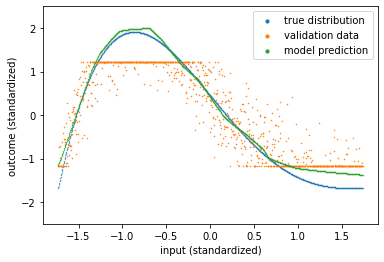

(1000,) (1000,) (1000,)


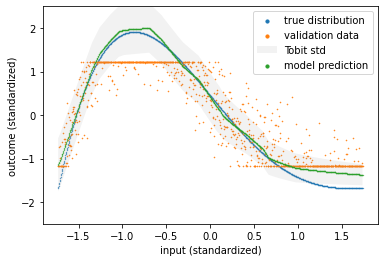

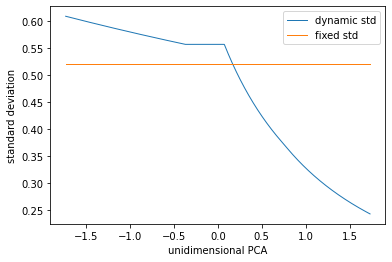

Absolute error - validation 0.1988130807876587
R2 - validation 0.8859755023548125
Absolute error - test 0.42836788296699524
R2 - test 0.8537301359278229


In [ ]:
# plot_and_evaluate_CEnsored(CHECKPOINT_DEEP_TOBIT_REPARAMETRIZED_TRUNCATED, model_fn = DenseNetwork, isGrid = False)
plot_and_evaluate_CEnsored(CHECKPOINT_DEEP_TOBIT_REPARAMETRIZED_TRUNCATED, model_fn = DenseNetwork, isGrid = True)

In [ ]:
grid_results = t.load(GRID_RESULTS_FILE)
best_config = grid_results['best']
best_metrics = grid_results[str(best_config)]
print(best_config)
print(best_metrics)

{'anneal_strategy': 'linear', 'base_momentum': 0.85, 'batch': 100, 'div_factor': 10, 'epochs': 20, 'final_div_factor': 10000.0, 'grad_clip': 100, 'max_lr': 0.001, 'max_momentum': 0.95, 'pct_start': 0.45, 'weight_decay': 0}
[2.66325378e+02 1.98813081e-01 8.85975502e-01]
